## Notebook that will evaluate the KNN model

In [1]:
#importing libraires to use
import sklearn.preprocessing as skl_pre
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy
from sklearn.metrics import confusion_matrix

#need to get the processing python file in another directory
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from process_data import process_data
from evaluate import evaluate_pred, print_dummy_evaluations
from visualization import plot_confusion_matrix

In [2]:
#getting the percentage splits of our training and testing data
# split_prec = {
#     'train': 0.8, 
#     'test': 0.2,
# }
#whatever scaler we will use
#scaler = skl_pre.StandardScaler()

#get the training and testing data
X_train, X_test, Y_train, Y_test = process_data()
print(X_train)
# print(X_test)
print(Y_train)
# print(Y_test)

Dropped columns: ['snow']
New columns: ['good_weather' 'is_day' 'temp_fahrenheit']
Split: "train" 	[Size: 1280] 	[Prec: 0.8]
	X: (1280, 17)
	Y: (1280,)
Split: "test" 	[Size: 320] 	[Prec: 0.2]
	X: (320, 17)
	Y: (320,)
      hour_of_day  day_of_week     month  holiday  weekday  summertime  \
0        0.652174     0.166667  0.272727      0.0      1.0         1.0   
1        0.000000     0.000000  0.545455      0.0      1.0         1.0   
2        0.826087     0.333333  0.818182      0.0      1.0         1.0   
3        0.000000     1.000000  0.454545      0.0      0.0         1.0   
4        0.869565     0.166667  0.727273      0.0      1.0         1.0   
...           ...          ...       ...      ...      ...         ...   
1275     1.000000     0.833333  0.636364      0.0      0.0         1.0   
1276     0.000000     0.833333  1.000000      0.0      0.0         0.0   
1277     0.304348     0.333333  0.727273      0.0      1.0         1.0   
1278     0.478261     0.500000  0.181818   

### Training we will only be working with X_train from here on down
Now that we have our training and test data we will run a KNN model on the training data with k-fold validation for hyperparameter tunning (what is a good value of k, distance measure to use, ect...). Then once we have a decent value of k we will "retrain" the model on the entire training data set and use that model on the test data which has never been seen and use the error from that as an estimation of $E_{new}$

In [3]:
#returns a trained KNN classifier that uses cross validation and grid search to find the best hyperparameters
def get_fitted_KNN(X,Y):
    #these are the hyperparameters that we are using Gridsearch to find
    parameters = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], "p" : [1,2,3], "weights" : ["uniform","distance"]}
    #running grid search over a KNN model with 25 fold cross validation.
    classifier = skl_ms.GridSearchCV(skl_nb.KNeighborsClassifier(), parameters, cv=25)
    #fit the best classifier
    classifier.fit(X,Y)
    #return it
    return classifier


Below we can see the expected $E_{new}$ of the training data only using cross validation and grid search in one

In [4]:
# print(np.array(Y_train.values.tolist()).reshape(-1,))
classifier = get_fitted_KNN(X_train,np.array(Y_train.values.tolist()).reshape(-1,))
print(classifier.best_params_)
print(classifier.best_score_)

{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.8663046757164404


Now that we have a way to hyperparameter tune and cross validate at the same time we will execute a semi-gridsearch method to determine which features we should use.  

Since the gridsearch in Sklearn uses cross validation we can assume the score it returns is an estiamtion of $E_{new}$ (even though this is an invalid estimation for the true $E_{new}$) for the "training" data. This is the score we want to try and increase because we are focusing on accuracy.  

So we will start with all the features and remove each one individually and see if the score increases. The feature removal that increases the score the most will be used and we will continue to do this until we plateau. Then that final model will be the one we use on the true test set to get our approximation of $E_{new}$

In [5]:
#this function will work through the trianing data and try to find a good column selection
def find_good_column_selection(df = X_train.join(Y_train), num_folds = 10):
    #get the columns for column selection
    xcols = df.columns.tolist()
    xcols.remove("increase_stock")
    ycols = "increase_stock"
    #Need to get a baseline classifier with all the columns
    baseline = get_fitted_KNN(df[xcols], df[ycols])
    #this variable will tell us when to stop
    score_increases = True
    #these are the hyperparameters we will be tunning and keeping track of
    #the baseline is a model that is fitted to all the parameters
    best_score = baseline.best_score_
    best_column_selection = xcols
    best_hyperparameters = baseline.best_params_
    while score_increases:
        #we are slowly going to remove columns to try and increase the score
        score_increases = False
        #loop through all the columns
        for col in xcols:
            print("Trying a new column selection")
            #remove one col at a time
            testing_cols = copy.copy(xcols)
            testing_cols.remove(col)
            print("Xcols",xcols)
            print("testingcols",testing_cols)
            #get our new fitted model with only one column removed
            model = get_fitted_KNN(df[testing_cols], df[ycols])
            score = model.best_score_
            #see if that model with the column removed does better
            if model.best_score_ > best_score:
                print("Found a better column selection")
                best_score = score
                best_column_selection = testing_cols
                best_hyperparameters = model.best_params_
                score_increases = True
        #need to reset the columns that we are looking 
        xcols = best_column_selection
    return (best_column_selection,best_hyperparameters,best_score)
results = find_good_column_selection()

Trying a new column selection
Xcols ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_fahrenheit', 'good_weather', 'is_day']
testingcols ['day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_fahrenheit', 'good_weather', 'is_day']
Trying a new column selection
Xcols ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_fahrenheit', 'good_weather', 'is_day']
testingcols ['hour_of_day', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_fahrenheit', 'good_weather', 'is_day']
Found a better column selection
Trying a new column selection
Xcols ['hour_of_day', 'd

In [6]:
results

(['hour_of_day',
  'day_of_week',
  'holiday',
  'weekday',
  'dew',
  'humidity',
  'snowdepth',
  'windspeed',
  'visibility',
  'temp_fahrenheit',
  'good_weather',
  'is_day'],
 {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'},
 0.8898039215686275)

In [14]:
best_cols = ['hour_of_day',
  'day_of_week',
  'holiday',
  'weekday',
  'dew',
  'humidity',
  'snowdepth',
  'windspeed',
  'visibility',
  'temp_fahrenheit',
  'good_weather',
  'is_day']
best_params = {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

In [15]:
#the best parameters for knn
results[1]

{'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

In [16]:
#training knn model with the best parameters
best_knn = skl_nb.KNeighborsClassifier(n_neighbors=best_params["n_neighbors"], p=best_params["p"], weights=best_params["weights"]).fit(X_train[results[0]],np.array(Y_train.values.tolist()).reshape(-1,))
best_knn.score(X_train[results[0]],Y_train)

0.9

In [17]:
#projected E_train with best found parameters
best_knn.score(X_test[results[0]],Y_test)

0.903125

In [18]:
y_pred = best_knn.predict(X_test[results[0]])
y_true = Y_test

metrics = evaluate_pred(y_pred, y_true)

print('-- Random Forest model --\n')
for metric, value in metrics.items():
    print(f'{metric.capitalize()}: \t{value}')

print('\n-- Dummy models -- ')
print_dummy_evaluations(X_train[results[0]], Y_train, X_test[results[0]], Y_test)

-- Random Forest model --

Accuracy: 	0.903125
Recall: 	0.58
Precision: 	0.7435897435897436

-- Dummy models -- 

Most_frequent
  Accuracy: 	0.84375
  Recall: 	0.0
  Precision: 	0.0

Stratified
  Accuracy: 	0.709375
  Recall: 	0.2
  Precision: 	0.15873015873015872

Uniform
  Accuracy: 	0.490625
  Recall: 	0.52
  Precision: 	0.15757575757575756


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


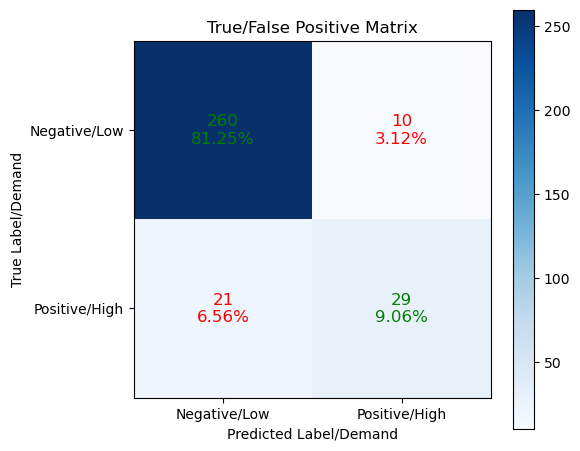

True Positive (TP): 29
True Negative (TN): 260
False Positive (FP): 10
False Negative (FN): 21


In [19]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
confusion_matrix_data = np.array([[tn, fp], [fn, tp]])
plot_confusion_matrix(confusion_matrix_data)

print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')